# DAML 08 - Classification vs Regression

Michal Grochmal <michal.grochmal@city.ac.uk>

How is *classification* different from *regression*?
Both techniques are a form of supervised learning,
i.e. require training data to have some kind of labels or values which represent the desired output.
It turns out that most classification methods can be used to perform regression
and most regression methods can be used to perform classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
plt.style.use('seaborn-talk')

### Logistic Regression

Imagine that we can construct a continuous function $f$ from a classification problem,
and then say that values below some value of $f(\vec{x}) = y_{decision}$ are from one class
and above this value are from the other class.
That is one common way of turning regression into binary classification (only two classes),
yet points with values very close to $y_{decision}$ would be often misclassified.

Instead, we can say that points with values close to $y_{decision}$ have a good probability
of being from either of the classes (with a little higher probability for the class on which
side of $y_{decision}$ the point is).
Points away from $y_{decision}$ will then have a big probability of being of one of the classes
and zero or almost zero probability of being from the other class.
This is what logical regression performs.
And several other classification techniques also perform this trick
with a **decision function** below the hood.

People say that a stew needs to be cooked for a long time to be good.
Let's see if we can classify stews based on their cooking time
and how the people who ate them liked them:

In [2]:
df = pd.DataFrame({
    'cooking time (h)': [0.2, 0.5, 0.6, 0.7, 1.0, 1.2, 1.3, 1.5, 1.9, 2.0, 2.5, 3.0, 3.7, 4.5],
    'satisfied eater':  [  0,   0,   0,   1,   0,   1,   0,   0,   1,   1,   1,   1,   1,   1]})
df

,cooking time (h),satisfied eater
0,0.2,0
1,0.5,0
2,0.6,0
3,0.7,1
4,1.0,0
5,1.2,1
6,1.3,0
7,1.5,0
8,1.9,1
9,2.0,1


We can see that it is more likely that a better cooked steak leaves a satisfied eater.
Yet where exactly is the boundary defined by this data is slightly more complicated.
If the measures were equally distributed we could take the mean of the classes on a scaled space.
But for that we would need to resample the cooking time.
An easier way is to fit a model, and we will try  logistic regression.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
model = LogisticRegression(C=1.5)
data = df['cooking time (h)'].values[:, np.newaxis]
y = df['satisfied eater']
cross_val_score(model, data, y, cv=3)

array([ 0.6,  0.8,  0.5])

What we are fitting is a continuous *logit* function that attempts to find
a good measure of the positive class (satisfied).

$$
\min_{w,c} C \sum_{i=1}^N log(exp(-y_i(X_i^T w + c) + 1) + \frac{\|w\|_2^2}{2}
$$

This produces a value between 0 and 1 for every sample in the dataset
and can be steered by the parameters inside the $w$ vector and the $C$ hyperparameter.
$w$ contains a parameter for every feature.
$C$ on the other hand is a *sensitivity* hyperparameter.
A very high $C$ will make the logit function never leave a sample
on the wrong side of the decision value, yet this may not converge.
A very small $C$ will make the solution tend to the mean for all samples.
As with most hyperparameters one should tune $C$ to the given problem.

The logit function fit has no analytical solution,
yet it is a convex problem with several constrains.
We can solve it in several *numerical* ways.

Let's use our trained model to check the probability of someone
being satisfied by the stew cooked by the following times.

In [4]:
model.fit(data, y)
model.predict([[0.3], [2.6]]), model.predict_proba([[0.3], [2.6]])

(array([0, 1]), array([[ 0.67858411,  0.32141589],
        [ 0.17279002,  0.82720998]]))

Every result give us *two* probabilities,
these are the probabilities to the negative and the positive classes, respectively.
The negative class, in a binary classification is just $1 - y$ of the positive class.
We can see it better if we plot both at the same time.

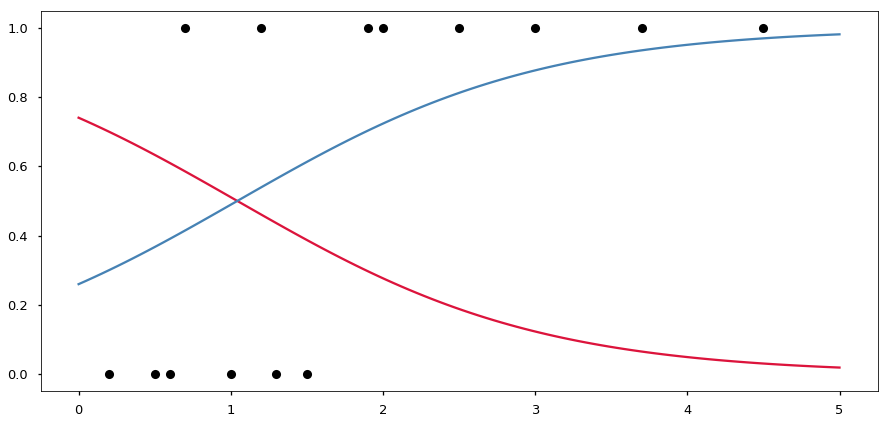

In [5]:
xfit = np.linspace(0, 5, 100)
yfit = model.predict_proba(xfit[:, np.newaxis])
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.plot(xfit, yfit[:, 0], color='crimson')
ax.plot(xfit, yfit[:, 1], color='steelblue')
ax.plot(data, y, 'o', color='black');

Using *logit* for classification is actually much more common than for regression.
Since logistic regression provides probabilities it is a good model to explain
the classification performed.

### Regression using KNN

On the other hand we can also use a classification technique to perform a regression.
When we count the neighbors in the $k$ nearest neighbors algorithm for classification
we take the class of the majority of neighbors.
But what if, instead of classes we have real values and we want a regressions?
We could simply take the mean of all the neighbors.
And this is exactly how a regressor based on KNN works.

Onto a problem: The foundation depth of a crane depends on what lift it will need to carry,
which in turn depends on the maximum weight and size (in the biggest dimension) of the load it may carry.
Let's try to estimate that foundation depth.
Here are some samples of foundation depth against their crane features.

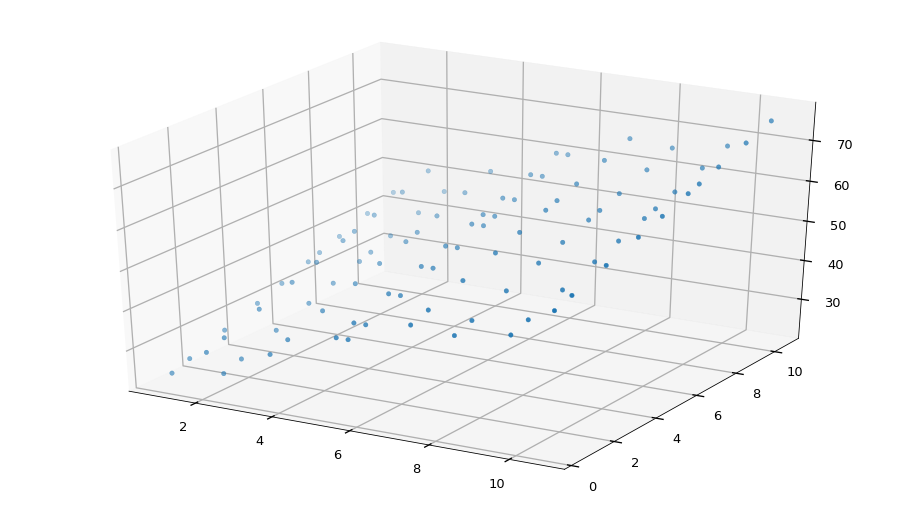

In [6]:
weight = np.linspace(0, 10, 10) + np.random.rand(10)
size = np.linspace(0, 10, 10) + np.random.rand(10)
w, s = np.meshgrid(weight, size)
lift_foundation = w*3 + s*2 + 17 + 7*np.random.rand(10)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(w, s, lift_foundation)
data = np.dstack([w, s]).reshape(100, 2)

This is a set with two features,
therefore we can visualize it easier with a 3 dimensional plot.
We can see an almost-plane forming,
we will estimate it based on data with a `KNeighborsRegressor`.
Before we used the $R2$ measure to score the regressions,
yet the $R2$ measure is particularly badly descriptive with KNN regressions.
This is because the regression uses means to explain large regions
and the variance of data within those regions is considered as "unexplained" by $R2$,
instead we will use plain explained variance to score our model.

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
model = KNeighborsRegressor(n_neighbors=3)
grid = GridSearchCV(model, {'n_neighbors': [3, 4, 5, 6, 7]}, scoring='explained_variance', cv=5)
grid.fit(data, lift_foundation.reshape(100))
print(grid.best_score_)
grid.best_estimator_

0.921986978068


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='uniform')

We have a reasonable score therefore we can be confident in our model.
One thing we should do is try to visualize how this model builds
the values it predicts.
We build a visualization by predicting lots of points with this model.

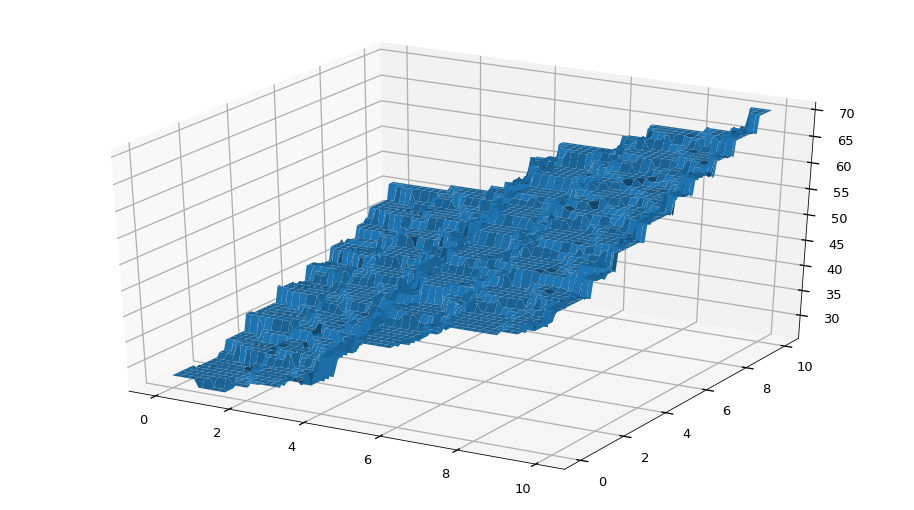

In [8]:
xmesh, ymesh = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 10, 100))
xfit = np.dstack([xmesh, ymesh]).reshape(10000, 2)
model = grid.best_estimator_
yfit = model.fit(data, lift_foundation.reshape(100))
yfit = model.predict(xfit)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xmesh, ymesh, yfit.reshape(100, 100));

Just like we can make areas where a certain class holds we can make areas
where a certain continuous value holds.
In simple words, the classification and regression problems are always related.
The techniques for classification and/or regression try to
either build a *decision function* across data points,
or divide the search space into *specific areas* which hold a label or value.